In [1]:
import urllib.request, json 

# 5min BTC/USDT chart form Poloniex since 2017-01-01T00:00:00+00:00 till 2018-10-14T20:00:00+00:00
with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1483228800&end=1539547200&period=300") as url:
    data = json.loads(url.read().decode())

In [2]:
print(data[0])

{'date': 1483228800, 'high': 965.00000066, 'low': 964.00000002, 'open': 965.00000055, 'close': 964.00000127, 'volume': 5398.83711674, 'quoteVolume': 5.59672254, 'weightedAverage': 964.64262399}


In [3]:
import csv
import numpy as np
import pandas as pd
 
df = pd.DataFrame(data=data, columns=['date', 'weightedAverage'])
        
df = df.fillna(method='ffill')
df.to_csv("poloniex_usdt_btc_20170101_weightedAverage_300.csv", sep=";", index=False)

df.head()

,date,weightedAverage
0,1483228800,964.642624
1,1483229100,965.858035
2,1483229400,963.946565
3,1483229700,962.024978
4,1483230000,963.568648


In [4]:
print(df.size)

375458


In [5]:
# Turn dataframe into a numpy floating point array
df_values = df.values
timestamps = df_values[:, 0]
dataset = df_values[:, 1].astype("float")

In [6]:
# Split the dataset into training (70%), cross validation (20%) and test (10%) set
samples_num = dataset.shape[0]

valid_split = 0.2
test_split = 0.1

dataset_train = dataset[0:int(samples_num * (1 - valid_split - test_split))]
dataset_valid = dataset[int(samples_num * (1 - valid_split - test_split)):int(samples_num * (1 - test_split))]
dataset_test = dataset[int(samples_num * (1 - test_split)):]

In [7]:
print(dataset_train.shape)
print(dataset_valid.shape)
print(dataset_test.shape)

(131410,)
(37546,)
(18773,)


In [8]:
print(dataset_train[:5])

[964.64262399 965.85803538 963.94656468 962.02497756 963.56864844]


In [9]:
# Makes a training examples from year data with a timesteps window size

def makeXy(data, timesteps):
    X = []
    y = []
    
    for i in range(timesteps, data.shape[0]):
        X.append(list(data[i-timesteps:i]))
        y.append(data[i])
        
    X, y = np.array(X), np.array(y)
    return X, y

In [10]:
print(np.array(dataset_train).shape)

(131410,)


In [11]:
print(np.array(dataset_train.shape).reshape(-1, 1))

[[131410]]


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

# Normalize data
scaler = StandardScaler().fit(np.array(dataset_train).reshape(-1, 1))
X_train = scaler.transform(np.array(dataset_train).reshape(-1, 1))
X_valid = scaler.transform(np.array(dataset_valid).reshape(-1, 1))
X_test = scaler.transform(np.array(dataset_test).reshape(-1, 1))

# Saving scaler for prediction
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

print ("X_train:\n" + str(X_train))
print ("\nX_valid:\n" + str(X_valid))
print ("\nX_test:\n" + str(X_test))

X_train:
[[-0.95438328]
 [-0.9541113 ]
 [-0.95453904]
 ...
 [ 0.3791661 ]
 [ 0.37897781]
 [ 0.37332536]]

X_valid:
[[0.37374208]
 [0.37158819]
 [0.36742356]
 ...
 [0.2704622 ]
 [0.27149772]
 [0.27376986]]

X_test:
[[0.27597285]
 [0.27707803]
 [0.27824451]
 ...
 [0.26215537]
 [0.2623948 ]
 [0.26275016]]


In [23]:
import numpy as np

timestep = 40 # Make decision from last 20 days

# Create training examples

train_X, train_y = makeXy(X_train, timestep)
valid_X, valid_y = makeXy(X_valid, timestep)
test_X, test_y = makeXy(X_test, timestep)
    
print(train_X.shape)
print(train_y.shape)

# train_X = train_X.reshape(train_X.shape[0],-1)
# valid_X = valid_X.reshape(valid_X.shape[0],-1)
# test_X = test_X.reshape(test_X.shape[0],-1)

# print(train_X.shape)
# print(train_y.shape)

(131370, 40, 1)
(131370, 1)


In [24]:
print(train_X[0])
print(train_y[0])

[[-0.95438328]
 [-0.9541113 ]
 [-0.95453904]
 [-0.95496905]
 [-0.95462361]
 [-0.95422342]
 [-0.95477771]
 [-0.9545387 ]
 [-0.9546288 ]
 [-0.95445073]
 [-0.95421625]
 [-0.95449726]
 [-0.95449726]
 [-0.95411198]
 [-0.95449726]
 [-0.95449726]
 [-0.95411418]
 [-0.95411198]
 [-0.95411198]
 [-0.95410895]
 [-0.95400951]
 [-0.95403426]
 [-0.95398963]
 [-0.95385606]
 [-0.95366915]
 [-0.95364846]
 [-0.95366168]
 [-0.9539117 ]
 [-0.95420145]
 [-0.95434963]
 [-0.95491691]
 [-0.95485802]
 [-0.95449233]
 [-0.95481109]
 [-0.95492997]
 [-0.95469605]
 [-0.95497464]
 [-0.9548161 ]
 [-0.9546958 ]
 [-0.95452765]]
[-0.95506427]


In [25]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.layers import Dropout, Conv1D, Flatten, MaxPooling1D, LSTM
from keras import regularizers
from tensorflow import set_random_seed

# Set random seed to always predict the same values
np.random.seed(1)
set_random_seed(2) # Tensoflow

In [26]:
# Saving loss and acc values

class TrainingHistory(Callback):

    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()

In [27]:
# train_X = np.expand_dims(train_X, axis=2)
# print(train_X.shape)

In [48]:
# Create model
model = Sequential()

model.add(Conv1D(kernel_size = (5), filters = 64, input_shape=train_X[0].shape, activation='relu'))
model.add(MaxPooling1D(pool_size = (2), strides=(2)))
model.add(Conv1D(kernel_size = (3), filters = 32, activation='relu'))
model.add(MaxPooling1D(pool_size = (2), strides=(2)))
model.add(LSTM(64))
model.add(Dense(1))
model.add(Activation('sigmoid'))


# model.add(Conv1D(kernel_size = (5), filters = 64, activation='relu'))
# model.add(MaxPooling1D(pool_size = (2), strides=(2)))
# model.add(Conv1D(kernel_size = (3), filters = 64, activation='relu'))
# model.add(MaxPooling1D(pool_size = (2), strides=(2)))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(80, activation='sigmoid'))
# model.add(Dropout(0.5))
# model.add(Dense(60, activation='sigmoid'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer= Adam())

model.save('model.h5') # Saving model for prediction

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 36, 64)            384       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 18, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 16, 32)            6176      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_9 (Activation)    (None, 1)                 0         
Total para

In [50]:
# Setting up early stopping and weight saving on actually best solutions

from keras.callbacks import EarlyStopping
patience=20
early_stopping=EarlyStopping(patience=patience, verbose=1)

from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

In [53]:
# Training model
model.fit(train_X[::1], train_y[::1],
          batch_size=64,
          epochs=2500,
          validation_data=(valid_X[::1],valid_y[::1]), 
          callbacks=[checkpointer, early_stopping, history], 
          shuffle= True)

Train on 131370 samples, validate on 37506 samples
Epoch 1/2500
131370/131370 [==============================] - 21s 160us/step - loss: 0.4808 - val_loss: 5.7447e-05

Epoch 00001: val_loss improved from 0.00006 to 0.00006, saving model to weights.hdf5
Epoch 2/2500
131370/131370 [==============================] - 21s 159us/step - loss: 0.4808 - val_loss: 5.3136e-05

Epoch 00002: val_loss improved from 0.00006 to 0.00005, saving model to weights.hdf5
Epoch 3/2500
131370/131370 [==============================] - 21s 163us/step - loss: 0.4808 - val_loss: 7.8888e-05

Epoch 00003: val_loss did not improve from 0.00005
Epoch 4/2500
131370/131370 [==============================] - 22s 166us/step - loss: 0.4808 - val_loss: 6.1806e-05

Epoch 00004: val_loss did not improve from 0.00005
Epoch 5/2500
131370/131370 [==============================] - 22s 167us/step - loss: 0.4808 - val_loss: 5.5842e-05

Epoch 00005: val_loss did not improve from 0.00005
Epoch 6/2500
131370/131370 [==================

KeyboardInterrupt: 

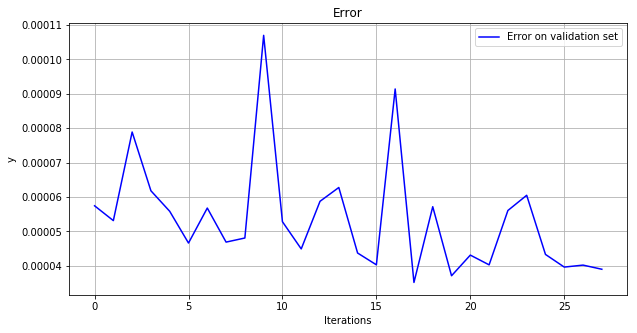

In [55]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.title('Error')
# plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Error on training set') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Error on validation set')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('y')
plt.grid(True)
plt.show()